In [1]:
from Py2P import core,sync,plot
from matplotlib import pyplot as plt
import os
import shutil

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
datapath = 'suite2p\\plane0\\'
syncfile = 'rec_000_000.mat'
sequencefile = 'stim_dict.json'

trials_names = {0:"IPSI",1:"CONTRA",2:"BOTH"}

In [ ]:
synchro = sync.Sync()
synchro.generate_data_structure(syncfile,sequencefile,trials_names)
rec = core.Rec2P(data_path=datapath, sync=synchro)
cells = rec.get_cells(keep_unresponsive=False)




> loading data from suite2p/plane0/ ... OK
> Using the parameters file found in data_path.
> parameters loaded.

> Extracting cells ...


100%|██████████| 516/516 [00:04<00:00, 117.32it/s]

> 108 responsive cells found (tot: 1024, keep_unresponsive: False, use_iscell: 1)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Computing 37 nearest neighbors...
[t-SNE] Indexed 108 samples in 0.000s...
[t-SNE] Computed neighbors for 108 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 108 / 108
[t-SNE] Mean sigma: 0.244690
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.694424
[t-SNE] KL divergence after 2100 iterations: 0.491287
True


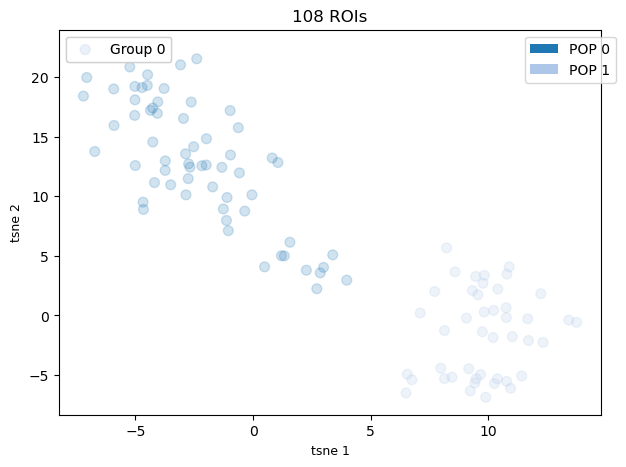

In [ ]:
### analyze and plot populations ###
import numpy as np
from sklearn.decomposition import PCA

fingerprints = rec.compute_fingerprints(stim_trials_dict={'chirp':['BOTH']},normalize='z')

tsne_params =  {
            'n_components':2, 
            'verbose':1, 
            'metric':'cosine', 
            'early_exaggeration':10, 
            'perplexity':12, 
            'n_iter':4000, 
            'init':'pca', 
            'angle':0.9}

transformed = core.TSNE_embedding(fingerprints,**tsne_params)
# transformed = PCA(n_components=2).fit_transform(fingerprints)

labels = core.GMM(transformed,**{'n_components':2,'covariance_type':'full'})

pops = []
for n in np.unique(labels):

    indices = np.squeeze(np.argwhere(labels == n))
    c = []
    for i in indices:

        c.append(rec.get_responsive()[i])

    pops.append(c)

plot.plot_clusters(transformed,labels,algo='tsne',l1loc='lower right',save='TSNE_populations')
# plot.plot_clusters(transformed,labels,algo='pca',l1loc='lower right',save='PCA_populations')


In [ ]:
### plot ###

import numpy as np

ordered_trials = list(trials_names.values())
stim_names = sorted(synchro.stims_names)

for id,pop in enumerate(pops):

    save_path = "POPULATION_#%d"%id

    if os.path.isdir(save_path):

        shutil.rmtree(save_path)

    os.mkdir(save_path)

    pop_cells = [cells[c] for c in pop]


    ### plot heatmap

    fig, axs = plt.subplots(len(trials_names),len(stim_names),figsize=(20,20))

    fig.suptitle('POPULATION #%d, N:%d'%(id,len(pop_cells)), fontsize=16)

    for i,trial in enumerate(ordered_trials):

        for j,stim in enumerate(stim_names):

            if not isinstance(axs, np.ndarray):

                ax = axs

            elif len(stim_names)==1:

                ax=axs[i]

            elif len(ordered_trials)==1:

                ax=axs[j]

            else:
                ax=axs[i,j]


            if trial in synchro.sync_ds[stim]:


                plot.plot_averages_heatmap(pop_cells, 
                                            synchro, 
                                            stims=stim, 
                                            trials=trial, 
                                            type='dff', 
                                            stim_bar=False,
                                            vmin=None, 
                                            vmax=None, 
                                            normalize='z', 
                                            cb_label="\u0394F/F (z-score)",
                                            ax=ax)

            else:

                ax.axis("off")

            if i == 0: ax.set_title(stim,fontsize=15)

    if len(ordered_trials)>1:

        for ax, trial in zip(axs, ordered_trials):

            ax[0].set_ylabel(trial,fontsize=18)
    else:

        ax.set_ylabel(trial,fontsize=18)

    plt.savefig(r"%s/heatmaps_dff.png"%save_path, bbox_inches="tight")
    plt.close(fig)

    ###
    #plot full heatmap
    fig, axs = plt.subplots(1,figsize=(10,7))
    fig.suptitle('POPULATION #%d, N:%d'%(id,len(pop_cells)), fontsize=16)

    plot.plot_averages_heatmap(pop_cells,
                                synchro,
                                full="dff",
                                vmin=None, 
                                vmax=None, 
                                normalize='z', 
                                cb_label="\u0394F/F (z-score)", 
                                stim_bar=False,
                                ax=axs)
    
    plt.savefig(r"%s/full_heatmap_dff.png"%save_path, bbox_inches="tight")
    plt.close(fig)

    ### plot averaged responses

    plot.plot_multipleStim(pop_cells, 
                           synchro, 
                           average=True, 
                           save=True, 
                           save_path=save_path, 
                           stims=None, 
                           trials=None, 
                           full='dff',
                           share_x=False, 
                           share_y=False,
                           group_trials=True, 
                           legend=True)


    # ### plot all the cells

    # save_path_allcells = save_path+r"/all_cells"

    # if os.path.isdir(save_path_allcells):

    #     shutil.rmtree(save_path_allcells)

    # os.mkdir(save_path_allcells)

    # plot.plot_multipleStim(pop_cells, 
    #                        synchro, 
    #                        average=False, 
    #                        save=True, 
    #                        save_path=save_path_allcells, 
    #                        stims=None, 
    #                        trials=None, 
    #                        full='dff',
    #                        share_x=False, 
    #                        share_y=False,
    #                        group_trials=False, 
    #                        legend=True)
    



c:\Users\micheli\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: vmin, vmax. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
Y:\Pietro\Scripts\libs\Py2P\plot.py:619: RuntimeWarning: Couldn't find a plotting function for stim 'contrast_ramp'
  warnings.warn("Couldn't find a plotting function for stim '%s'"%stim, RuntimeWarning)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


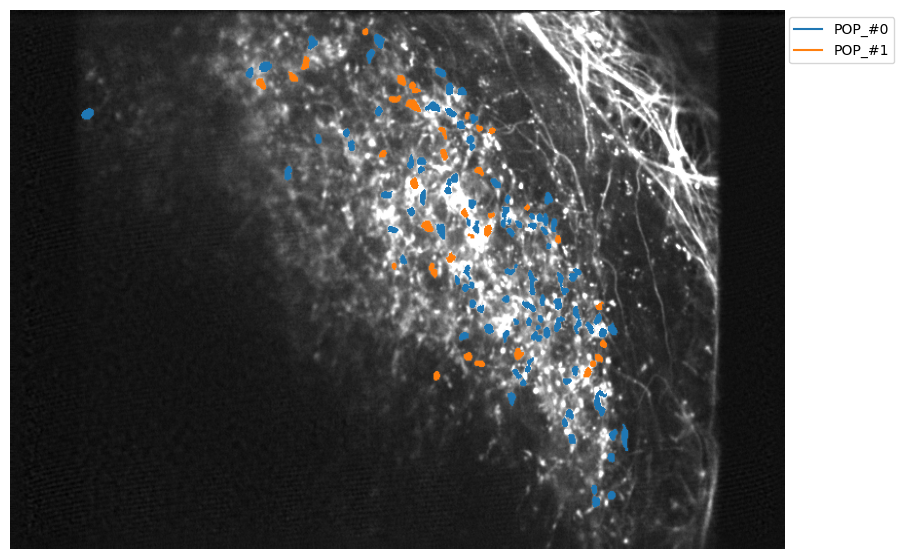

In [ ]:
## plot FOV
plot.plot_FOV(pops, rec, k=5)